In [104]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import gridspec
import copy
import os
from tqdm import tqdm 

from EightBitTransit.cTransitingImage import TransitingImage
from EightBitTransit.inversion import *
from EightBitTransit.misc import *
from scipy.optimize import lsq_linear

%matplotlib inline


import matplotlib.path as mpath
import matplotlib.patches as mpatches
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Polygon
from matplotlib.patches import Rectangle
from matplotlib.patches import Wedge


from PIL import Image 


# Add spocc directory to the path to import spocc modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import data
import loaders


# These "magic" functions work in jupyter notebooks, this one reloads
# modules so if you make changes, you don't have to restart the notebook.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [221]:
#round shapes


def make_shape(image_ratio, velocity, shape, t_ref):
    
    image_ratio = image_ratio
    image_ratio_high = 1 + .5* (image_ratio -1)
    image_ratio_low = -.5 * (image_ratio-1)
    print(image_ratio_high, image_ratio_low)
    
    v = float(velocity)

    if shape == 'Circle':
        circle = plt.Circle((0.5, 0.5), 0.5, color='black')

        fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
        # (or if you have an existing figure)
        # fig = plt.gcf()
        # ax = fig.gca()

        ax.add_patch(circle)
        ax.set_aspect('equal', adjustable='box')

        plt.axis('off')
        plt.xlim(0,1)
        plt.ylim(image_ratio_low,image_ratio_high)
        
        os.makedirs(data_dir + "/Class_%s" %(shape), exist_ok=True)
        img_file_name = data_dir + "/Class_%s" %(shape) + "/%s" %(shape)  +"_ratio_%s" %(image_ratio) +"_velocity_%s.png" %(velocity)
        fig.savefig(img_file_name ,bbox_inches='tight', pad_inches = 0)

    if shape == 'Triangle':
        pts = np.array([[0,0], [1,0], [.5,0.866025]],)
        p = Polygon(pts, closed=False, fc = 'black')
        ax = plt.gca()
        ax.add_patch(p)
        ax.set_aspect('equal', adjustable='box')
        plt.axis('off')
        plt.xlim(0,1)
        plt.ylim(image_ratio_low,image_ratio_high)

        os.makedirs(data_dir + "/Class_%s" %(shape), exist_ok=True)
        img_file_name = data_dir + "/Class_%s" %(shape) + "/%s" %(shape)  +"_ratio_%s" %(image_ratio) +"_velocity_%s.png" %(velocity)
        plt.savefig(img_file_name ,bbox_inches='tight', pad_inches = 0)
    
    if shape == 'Square':
        plt.axes()
        square = plt.Rectangle((0,0),1,1, fc='black',ec="black")
        plt.gca().add_patch(square)
        plt.axis('scaled')

        plt.axis('off')
        plt.ylim(image_ratio_low,image_ratio_high)
        plt.xlim(0,1)


        #display plot
        plt.gcf()
        plt.savefig('square.png',bbox_inches='tight', pad_inches = 0)
        
        os.makedirs(data_dir + "/Class_%s" %(shape), exist_ok=True)
        img_file_name = data_dir + "/Class_%s" %(shape) + "/%s" %(shape)  +"_ratio_%s" %(image_ratio) +"_velocity_%s.png" %(velocity)
        plt.savefig(img_file_name ,bbox_inches='tight', pad_inches = 0)

    
    if shape == 'Donut':
        outer_circle = plt.Circle((0.5, 0.5), 0.5, color='black')
        inner_circle = plt.Circle((0.25, 0.5), 0.2, facecolor='white', edgecolor='white')

        fig, ax = plt.subplots()
        ax.add_patch(outer_circle)
        ax.add_patch(inner_circle)
        ax.set_aspect('equal', adjustable='box')

        plt.axis('off')
        plt.xlim(0, 1)
        plt.ylim(image_ratio_low, image_ratio_high)
        plt.show()

        os.makedirs(data_dir + "/Class_%s" % shape, exist_ok=True)
        img_file_name = (
            data_dir
            + "/Class_%s" % shape
            + "/%s" % shape
            + "_ratio_%s" % image_ratio
            + "_velocity_%s.png" % velocity
        )
        fig.savefig(img_file_name, bbox_inches='tight', pad_inches=0, transparent =True)
        
    if shape == 'Panels':
        plt.axes()
        square = plt.Rectangle((0,0),6,1, fc='black',ec="black")
        inner_circle = plt.Circle((3, .25), .25, facecolor='white', edgecolor='white')

        plt.gca().add_patch(square)
        plt.gca().add_patch(inner_circle)

        plt.axis('scaled')

        plt.axis('off')
        plt.ylim(image_ratio_low,image_ratio_high)
        plt.xlim(0,6)


        #display plot
        plt.gcf()
        plt.savefig('square.png',bbox_inches='tight', pad_inches = 0)
        
        os.makedirs(data_dir + "/Class_%s" %(shape), exist_ok=True)
        img_file_name = data_dir + "/Class_%s" %(shape) + "/%s" %(shape)  +"_ratio_%s" %(image_ratio) +"_velocity_%s.png" %(velocity)
        plt.savefig(img_file_name ,bbox_inches='tight', pad_inches = 0)

    #######
    
    # Read back in the image file.

    # an array of times, in days, over which to calculate the light curve 
    times = np.linspace(0,27,1296)

    file = img_file_name

    lowres_SItitle = TransitingImage(imfile=file,
                                     lowres=50,
                                     lowrestype="mean", # Calculate the lower-resolution version of the image by averaging "neighborhoods" of pixels in the high-res image.
                                     lowresround=False, # Let the resulting low-res pixel values take on intermediate values between 0 and 1, i.e. don't round them to 0 or 1.
                                     v=velocity,
                                     t_ref=t_ref,
                                     t_arr=times,
                                     LDlaw = "linear",
                                     LDCs = [0.4]
                                    )
    ##plot lowres version of image
    lowres_SItitle.plot_grid()
    
    lowres_SItitle_LC, overlapTimes = lowres_SItitle.gen_LC(t_arr=times) 
    
    #plot lightcurve
    fig, ax = plt.subplots(1,1,figsize=(16,4))
    ax.plot(overlapTimes,lowres_SItitle_LC,color="#1969ea",ls="-",lw=5)
    #ax.set_xlim(-10,10)
    plt.xlabel("Time [days]",fontsize=14)
    plt.ylabel("Relative flux",fontsize=14)
    plt.title(r"The low-res image's light curve as it transits left-to-right across the star at $v = 0.3 d^{-1}$",fontsize=16)
    plt.show()
    
    print("min: " + str(min(lowres_SItitle_LC)))

    
    list_of_tuples = list(zip(overlapTimes, lowres_SItitle_LC))
    
    txt_file_name = data_dir + "/Class_%s" %(shape) + "/%s" %(shape)  +"_ratio_%s" %(image_ratio) +"_velocity_%s" %(velocity)
    
    df = pd.DataFrame(list_of_tuples, columns=['Time', 'Flux'])
    df.to_csv(txt_file_name + '.csv', index=False)
    
    #np.savetxt(txt_file_name, lowres_SItitle_LC, delimiter=",")


In [249]:
np.random.seed() #how do we want to add LCs to TESS curves?
import math

def make_lc(shape, image_ratio, velocity, index):
    #shape = "Triangle"
    #ratio = "2"
    #index=3

    f0 = data_dir+subref.Filename.values[index]
    lc = loaders.load_lc(f0)
    #print(lc)
    lc = lc[lc.quality==0]
    lc = lc.normalize()
    flux_err = lc.flux_err
    #print(f0)
    #print(flux_err[0])
    #print(lc.time.value)
    time = lc.time.value
    time = [value - time[0] for value in time] #make time start at 0
    # plt.scatter(time, lc.flux.value)
    # plt.title("TESS Flux Only")
    # plt.show()


    noise = pd.read_csv('/home/jupyter/SPOcc/spocc/notebooks/Random_LCs_tic251630511/Class_%s' %(shape) + "/%s" %(shape)  +"_ratio_%s" %(image_ratio) +"_velocity_%s" %(velocity)+'.csv')

    sim_time = noise.iloc[:,0].values
    sim_flux = noise.iloc[:,1].values
    sim_flux = [x - 1 for x in sim_flux]


    #print(sim_time)
    # plt.scatter(sim_time, sim_flux)
    # plt.title("Flux From 8BT")
    # plt.show()
    #print(sim_time[-1])

    after_interval = math.ceil((27 - sim_time[-1]) / 0.0208333333) #days to 30 minutes

    sim_time_after = np.linspace(math.ceil(sim_time[-1]), 27, after_interval)
    #print(sim_time_after)

    sim_time = np.append(sim_time, sim_time_after)


    sim_flux_after = np.zeros(len(sim_time_after))

    sim_flux = np.append(sim_flux,sim_flux_after)

    before_interval = math.ceil((sim_time[0]) / 0.0208333333) #days to 30 minutes

    sim_time_before = np.linspace(0, math.floor(sim_time[0]), before_interval)
    #print(sim_time_before)

    sim_time = np.insert(sim_time, 0, sim_time_before)


    sim_flux_before = np.zeros(len(sim_time_before))

    sim_flux = np.insert(sim_flux, 0, sim_flux_before)    



#     plt.scatter(sim_time, sim_flux)
#     plt.title("Extended 8BT Flux")
#     plt.ylabel("Relative flux",fontsize=14)

#     plt.show()

    sim_flux = np.interp(time, sim_time, sim_flux) 
    #print(sim_flux)

    combined_flux = lc.flux.value + sim_flux

#     plt.scatter(time, sim_flux)
#     plt.title("Interpolated 8BT Flux")
#     plt.show()
    plt.title("Combined 8BT & TESS Flux")
    plt.plot(time, combined_flux)
    plt.xlabel("Time [days]",fontsize=14)
    #plt.show()


    os.makedirs('./Injected_LCs_tic251630511', exist_ok=True)


    list_of_tuples = list(zip(time, combined_flux, flux_err))

    txt_file_name = './Injected_LCs_tic251630511' + "/%s" %(shape)  +"_ratio_%s" %(image_ratio) +"_velocity_%s" %(velocity)


    df = pd.DataFrame(list_of_tuples, columns=['Time', 'Flux', 'Flux_err'])
    df.to_csv(txt_file_name + '.csv', index=False)

1.039163866017192 -0.03916386601719213


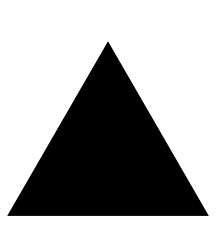

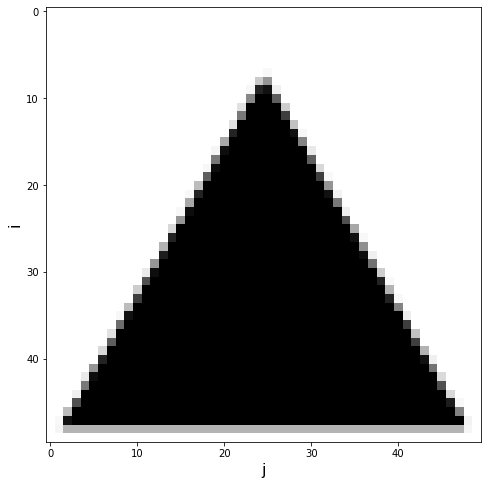

/opt/conda/envs/spocc/lib/python3.6/site-packages/ipykernel_launcher.py:135: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


KeyboardInterrupt: 

In [259]:
#make EightBitTransit LC

data_dir = "./Random_LCs_tic251630511"

t_ref = 18 #time in days of transit

shape = 'Triangle'
w_or_d = 'D'

#image_ratio = 2 #2 for square/circle, 1.4 for triangle widths

if shape == 'Triangle':
    image_ratios = np.array([0.07, 0.16, 0.25, 0.34, 0.43, .49]) #TRIANGLES
    image_ratios = 1/ np.sqrt(1- 2*image_ratios)
    image_ratio = 1.4

else:
    image_ratios = np.array([0.07, 0.16, 0.25, 0.34, 0.43, 0.52, 0.61, 0.70, 0.79, 0.88, 0.97, .99])
    image_ratios = 1/ np.sqrt(1- image_ratios)
    image_ratio = 2
    
velocities = np.array([.3, .4 , .5, .6, .7, .8, .9, 1.0, 1.2, 1.4, 1.6, 1.8])
velocity = 0.6
if w_or_d == 'W':
    for velocity in velocities:
        make_shape(image_ratio, velocity, shape, t_ref)
elif w_or_d == 'D':
    for image_ratio in image_ratios:
        make_shape(image_ratio, velocity, shape, t_ref)


In [261]:
# Mount data either from disk or bucket

data_dir = "/home/jupyter/mountpoint/"  # path for bucket

ref = loaders.load_ref(18, data_dir) #sector 18 camera 2

subref = ref[ref.TIC_ID.isin([251630511])]#377199128 # overplot with this anomalous
print(subref)

                                               Filename         RA        Dec  \
3414  tesslcs_sector_18_104/2_min_cadence_targets/te...  46.056424  56.797328   

         TIC_ID  Sector  Camera  CCD  Magnitude  
3414  251630511      18       2    4    12.8186  


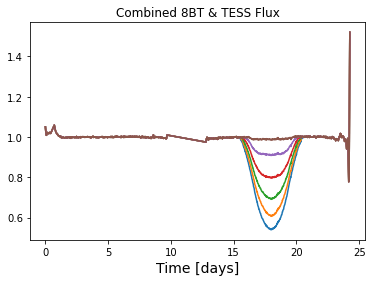

In [262]:
#inject into TESS data
shape = 'Triangle'#'Circle'
index= 0
velocity = 0.6#velocity
image_ratio = 1.4 #image_ratio
w_or_d = 'D'

if w_or_d == 'W':
    for velocity in velocities:
        image_ratio = str(image_ratio)
        velocity = str(velocity)
        make_lc(shape, image_ratio, velocity, index)
if w_or_d == 'D':
    for image_ratio in image_ratios:
        image_ratio = str(image_ratio)
        velocity = str(velocity)
        make_lc(shape, image_ratio, velocity, index)

plt.show()

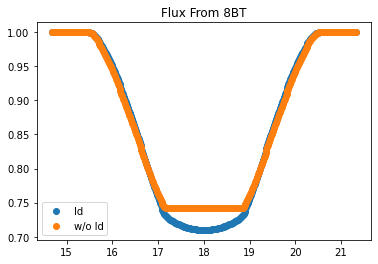

In [74]:
#check any previously run lcs

noise = pd.read_csv('/home/jupyter/SPOcc/spocc/notebooks/Random_LCs_tic251630511/Class_Circle/Circle_ratio_2_velocity_0.6_ld.csv')

sim_time = noise.iloc[:,0].values
sim_flux = noise.iloc[:,1].values


plt.scatter(sim_time, sim_flux, label = "ld")
plt.title("Flux From 8BT")

noise = pd.read_csv('/home/jupyter/SPOcc/spocc/notebooks/Random_LCs_tic251630511/Class_Circle/Circle_ratio_2_velocity_0.6.csv')

sim_time = noise.iloc[:,0].values
sim_flux = noise.iloc[:,1].values


plt.scatter(sim_time, sim_flux, label = "w/o ld")
plt.title("Flux From 8BT")
plt.legend()
plt.show()

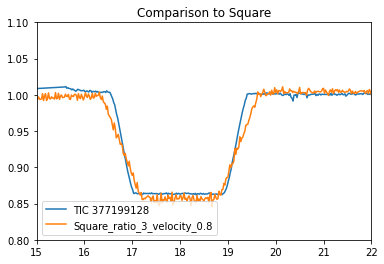

In [66]:
#compare TIC 377199128 with shapes
subref = ref[ref.TIC_ID==377199128] 
f0 = data_dir+subref.Filename.values[index]
lc = loaders.load_lc(f0)
lc = lc[lc.quality==0]
lc = lc.normalize()
#print(f0)
#print(flux_err[0])
#print(lc.time.value)
time = lc.time.value
time = [value - time[0] +2.8 for value in time] #make time start at 0
plt.plot(time, lc.flux.value, label = "TIC 377199128")

file = "Square_ratio_3_velocity_0.8.csv"
df = pd.read_csv('/home/jupyter/SPOcc/examples/EightBitTransit/examples/Injected_LCs/'+ file)
flux = df['Flux'] 
plt.plot(df['Time'], flux, label = file[:-4])




plt.title("Comparison to " + str(file[:-25]))


plt.ylim(.8, 1.1)
plt.xlim(15,22)
plt.legend(loc = 'lower left')
plt.show()


0


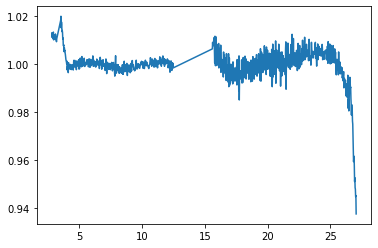

In [37]:
#look at bare lightcurves
import pandas as pd
subref = ref[ref.TIC_ID==453152796] 
f0 = data_dir+subref.Filename.values[index]
lc = loaders.load_lc(f0)
lc = lc[lc.quality==0]
lc = lc.normalize()
#print(f0)
#print(flux_err[0])
#print(lc.time.value)
time = lc.time.value
time = [value - time[0] +2.8 for value in time] #make time start at 0
plt.plot(time, lc.flux.value, label = "TIC 453152796")

#df = pd.Dataframe({'Time': time, 'Flux': lc.flux.value})
#print(df)
print(index)